# Unit08_Apriori_Algorithm | 關聯規則學習：Apriori 演算法

本 Notebook 使用模擬的聚合物配方數據，示範如何使用 Apriori 演算法進行關聯規則挖掘。

## 目標
- 理解 Apriori 演算法的工作原理
- 學會使用 mlxtend 套件實作 Apriori
- 從化工配方數據中發現有價值的關聯規則
- 評估和解讀關聯規則
- 視覺化關聯規則網絡

資料背景：模擬的聚合物配方數據，包含單體、引發劑、鏈轉移劑、溶劑、溫度、時間等變數，以及產品品質指標（分子量分布、轉化率、純度）。

---
### 0. 環境設定

In [12]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit08_Apriori_Algorithm'
SOURCE_DATA_DIR = 'polymer_formulations'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit08'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\data\polymer_formulations
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_Apriori_Algorithm
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_Apriori_Algorithm\figs


---
### 1. 載入相關套件

In [13]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Association Rule Mining 套件
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# 網絡圖視覺化
import networkx as nx

# 設定隨機種子以確保結果可重現
SEED = 42
np.random.seed(SEED)

# 設定matplotlib中文顯示
plt.rcParams['axes.unicode_minus'] = False

print("✓ 套件載入完成")

✓ 套件載入完成


---
### 2. 數據準備：模擬聚合物配方數據

我們將模擬一個聚合物配方數據集，包含以下要素：
- **單體類型** (A, B, C, D, E)
- **引發劑類型** (I1, I2, I3)
- **鏈轉移劑類型** (T1, T2, T3) - 可選
- **溶劑類型** (S1, S2, S3)
- **溫度範圍** (低溫、中溫、高溫)
- **反應時間** (短時間、中時間、長時間)
- **產品品質指標**：
  - 分子量分布 (窄、中、寬)
  - 轉化率 (高、中、低)
  - 純度 (高、中、低)

我們將在數據中嵌入一些關聯規則：
1. {單體A, 引發劑I1} → {窄分子量分布}
2. {溶劑S1, 高溫} → {高轉化率}
3. {鏈轉移劑T2, 中溫} → {高純度}

In [14]:
# 定義項目
monomers = ['Monomer_A', 'Monomer_B', 'Monomer_C', 'Monomer_D', 'Monomer_E']
initiators = ['Initiator_I1', 'Initiator_I2', 'Initiator_I3']
chain_transfer = ['Chain_Transfer_T1', 'Chain_Transfer_T2', 'Chain_Transfer_T3']
solvents = ['Solvent_S1', 'Solvent_S2', 'Solvent_S3']
temperatures = ['Low_Temp', 'Medium_Temp', 'High_Temp']
times = ['Short_Time', 'Medium_Time', 'Long_Time']

# 生成 200 筆配方交易（增加樣本量以提高統計顯著性）
n_transactions = 200
transactions = []

print(f"生成 {n_transactions} 筆配方數據...")

for i in range(n_transactions):
    transaction = []
    
    # 每個配方包含 1 種單體（提高 Monomer_A 的出現機率）
    if np.random.rand() < 0.35:  # 35% 機率選擇 Monomer_A
        monomer = 'Monomer_A'
    else:
        monomer = np.random.choice(monomers)
    transaction.append(monomer)
    
    # 1 種引發劑（如果是 Monomer_A，更傾向選擇 Initiator_I1）
    if monomer == 'Monomer_A' and np.random.rand() < 0.6:  # 60% 機率配對
        initiator = 'Initiator_I1'
    else:
        initiator = np.random.choice(initiators)
    transaction.append(initiator)
    
    # 60% 機率添加鏈轉移劑（提高 T2 出現率）
    if np.random.rand() > 0.4:
        if np.random.rand() < 0.4:  # 40% 選擇 T2
            ct = 'Chain_Transfer_T2'
        else:
            ct = np.random.choice(chain_transfer)
        transaction.append(ct)
    
    # 1 種溶劑（提高 Solvent_S1 的出現機率）
    if np.random.rand() < 0.35:  # 35% 機率選擇 S1
        solvent = 'Solvent_S1'
    else:
        solvent = np.random.choice(solvents)
    transaction.append(solvent)
    
    # 1 種溫度條件（與溶劑和鏈轉移劑協調）
    if solvent == 'Solvent_S1' and np.random.rand() < 0.5:  # S1 傾向高溫
        temp = 'High_Temp'
    elif 'Chain_Transfer_T2' in transaction and np.random.rand() < 0.6:  # T2 傾向中溫
        temp = 'Medium_Temp'
    else:
        temp = np.random.choice(temperatures)
    transaction.append(temp)
    
    # 1 種時間條件
    time = np.random.choice(times)
    transaction.append(time)
    
    # 根據組合決定品質（模擬協同效應）
    # 規則 1: 單體A + 引發劑I1 → 窄分子量分布 (90% 機率)
    if monomer == 'Monomer_A' and initiator == 'Initiator_I1':
        if np.random.rand() < 0.90:
            transaction.append('Narrow_MW_Distribution')
        else:
            transaction.append(np.random.choice(['Medium_MW_Distribution', 'Wide_MW_Distribution']))
    else:
        # 降低背景噪音：非目標組合傾向非目標結果
        mw_probs = [0.15, 0.40, 0.45]  # [窄, 中, 寬]
        transaction.append(np.random.choice(['Narrow_MW_Distribution', 'Medium_MW_Distribution', 'Wide_MW_Distribution'], p=mw_probs))
    
    # 規則 2: 溶劑S1 + 高溫 → 高轉化率 (90% 機率)
    if solvent == 'Solvent_S1' and temp == 'High_Temp':
        if np.random.rand() < 0.90:
            transaction.append('High_Conversion')
        else:
            transaction.append(np.random.choice(['Medium_Conversion', 'Low_Conversion']))
    else:
        # 降低背景噪音
        conv_probs = [0.25, 0.45, 0.30]  # [高, 中, 低]
        transaction.append(np.random.choice(['High_Conversion', 'Medium_Conversion', 'Low_Conversion'], p=conv_probs))
    
    # 規則 3: 鏈轉移劑T2 + 中溫 → 高純度 (90% 機率)
    if 'Chain_Transfer_T2' in transaction and temp == 'Medium_Temp':
        if np.random.rand() < 0.90:
            transaction.append('High_Purity')
        else:
            transaction.append(np.random.choice(['Medium_Purity', 'Low_Purity']))
    else:
        # 降低背景噪音
        purity_probs = [0.20, 0.50, 0.30]  # [高, 中, 低]
        transaction.append(np.random.choice(['High_Purity', 'Medium_Purity', 'Low_Purity'], p=purity_probs))
    
    transactions.append(transaction)

print(f"✓ 成功生成 {len(transactions)} 筆配方數據")
print(f"\n前5筆配方範例:")
for i, trans in enumerate(transactions[:5], 1):
    print(f"  配方 {i}: {trans}")

生成 200 筆配方數據...
✓ 成功生成 200 筆配方數據

前5筆配方範例:
  配方 1: ['Monomer_E', 'Initiator_I3', 'Chain_Transfer_T3', 'Solvent_S3', 'High_Temp', 'Long_Time', 'Wide_MW_Distribution', 'Medium_Conversion', 'Low_Purity']
  配方 2: ['Monomer_A', 'Initiator_I2', 'Solvent_S1', 'High_Temp', 'Medium_Time', 'Medium_MW_Distribution', 'High_Conversion', 'Medium_Purity']
  配方 3: ['Monomer_B', 'Initiator_I3', 'Chain_Transfer_T3', 'Solvent_S1', 'High_Temp', 'Long_Time', 'Wide_MW_Distribution', 'High_Conversion', 'High_Purity']
  配方 4: ['Monomer_B', 'Initiator_I2', 'Solvent_S1', 'High_Temp', 'Long_Time', 'Wide_MW_Distribution', 'High_Conversion', 'High_Purity']
  配方 5: ['Monomer_B', 'Initiator_I2', 'Chain_Transfer_T2', 'Solvent_S1', 'Medium_Temp', 'Medium_Time', 'Wide_MW_Distribution', 'Medium_Conversion', 'Low_Purity']


---
### 3. 數據轉換：One-Hot Encoding

Apriori 演算法要求數據為 One-Hot Encoding 格式，我們使用 `TransactionEncoder` 進行轉換。

In [15]:
# 使用 TransactionEncoder 轉換為 One-Hot Encoding
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_).astype(bool)

print(f"✓ 數據轉換完成")
print(f"  數據集大小: {df.shape[0]} 筆交易 × {df.shape[1]} 個項目")
print(f"  數據類型: {df.dtypes[0]}")
print(f"\n前5筆數據 (One-Hot Encoding):")
print(df.head())

# 統計每個項目出現的頻率
item_counts = df.sum().sort_values(ascending=False)
print(f"\n各項目出現頻率 (Top 10):")
print(item_counts.head(10))

✓ 數據轉換完成
  數據集大小: 200 筆交易 × 29 個項目
  數據類型: bool

前5筆數據 (One-Hot Encoding):
   Chain_Transfer_T1  Chain_Transfer_T2  Chain_Transfer_T3  High_Conversion  \
0              False              False               True            False   
1              False              False              False             True   
2              False              False               True             True   
3              False              False              False             True   
4              False               True              False            False   

   High_Purity  High_Temp  Initiator_I1  Initiator_I2  Initiator_I3  \
0        False       True         False         False          True   
1        False       True         False          True         False   
2         True       True         False         False          True   
3         True       True         False          True         False   
4        False      False         False          True         False   

   Long_Time  ...  Mono

---
### 4. Apriori 演算法：尋找頻繁項目集

使用 Apriori 演算法找出支持度 ≥ 8% 的頻繁項目集（200 筆交易 × 0.08 = 至少出現 16 次）。

In [16]:
# 使用 Apriori 找出頻繁項目集
min_support = 0.08  # 降低至 8% 以發現更多規則（200筆×0.08=16次）
max_len = 5  # 增加至 5 以探索更複雜的組合

print(f"執行 Apriori 演算法...")
print(f"  最小支持度: {min_support}")
print(f"  最大項目集大小: {max_len}")

frequent_itemsets = apriori(
    df, 
    min_support=min_support, 
    use_colnames=True,
    max_len=max_len
)

print(f"\n✓ 找到 {len(frequent_itemsets)} 個頻繁項目集")

# 按支持度排序並顯示
frequent_itemsets_sorted = frequent_itemsets.sort_values('support', ascending=False)
print(f"\n前20個頻繁項目集 (按支持度排序):")
print(frequent_itemsets_sorted.head(20))

# 統計不同大小的頻繁項目集數量
itemset_size_counts = frequent_itemsets['itemsets'].apply(len).value_counts().sort_index()
print(f"\n頻繁項目集大小分布:")
for size, count in itemset_size_counts.items():
    print(f"  大小 {size}: {count} 個")

執行 Apriori 演算法...
  最小支持度: 0.08
  最大項目集大小: 5

✓ 找到 415 個頻繁項目集

前20個頻繁項目集 (按支持度排序):
     support                                           itemsets
6      0.575                                     (Initiator_I1)
25     0.540                                       (Solvent_S1)
5      0.485                                        (High_Temp)
18     0.480                                        (Monomer_A)
3      0.460                                  (High_Conversion)
15     0.430                                    (Medium_Purity)
23     0.425                           (Narrow_MW_Distribution)
97     0.375             (Narrow_MW_Distribution, Initiator_I1)
96     0.370                          (Monomer_A, Initiator_I1)
44     0.370                       (High_Temp, High_Conversion)
17     0.370                                      (Medium_Time)
84     0.360                            (High_Temp, Solvent_S1)
176    0.355                (Monomer_A, Narrow_MW_Distribution)
57     0.350         

---
### 5. 生成關聯規則

從頻繁項目集中生成關聯規則，並使用置信度和提升度進行過濾。

In [17]:
# 生成關聯規則
min_confidence = 0.5  # 降低至 0.5 以發現更多規則

print(f"生成關聯規則...")
print(f"  最小置信度: {min_confidence}")

# 確保 itemsets 列中的元素類型正確（修正 mlxtend 的類型轉換問題）
frequent_itemsets['itemsets'] = frequent_itemsets['itemsets'].apply(
    lambda x: frozenset([str(item) for item in x])
)

rules = association_rules(
    frequent_itemsets, 
    metric="confidence", 
    min_threshold=min_confidence
)

print(f"\n✓ 找到 {len(rules)} 條關聯規則")

# 過濾高品質規則 (Lift > 1.5, Confidence > 0.65)
quality_rules = rules[
    (rules['lift'] > 1.5) &
    (rules['confidence'] > 0.65)
].sort_values('lift', ascending=False)

print(f"\n高品質規則 (Lift > 1.5, Confidence > 0.65): {len(quality_rules)} 條")
print(f"\n前15條高品質規則:")
print(quality_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(15))

生成關聯規則...
  最小置信度: 0.5

✓ 找到 825 條關聯規則

高品質規則 (Lift > 1.5, Confidence > 0.65): 368 條

前15條高品質規則:
                                           antecedents  \
555              (Narrow_MW_Distribution, High_Purity)   
770    (High_Temp, Solvent_S1, Narrow_MW_Distribution)   
722               (Monomer_A, High_Temp, Initiator_I1)   
725         (Monomer_A, High_Conversion, Initiator_I1)   
774  (High_Conversion, Solvent_S1, Narrow_MW_Distri...   
776           (Monomer_A, Solvent_S1, High_Conversion)   
388     (Medium_Temp, Initiator_I1, Chain_Transfer_T2)   
748    (High_Temp, Solvent_S1, Narrow_MW_Distribution)   
80                    (Medium_Temp, Chain_Transfer_T2)   
724  (High_Conversion, Narrow_MW_Distribution, Init...   
387     (Chain_Transfer_T2, Initiator_I1, High_Purity)   
719  (High_Temp, Narrow_MW_Distribution, Initiator_I1)   
79                    (Chain_Transfer_T2, High_Purity)   
702     (Medium_Purity, High_Conversion, Initiator_I1)   
718     (Monomer_A, High_Temp, Na

---
### 6. 規則分析：驗證嵌入的關聯模式

檢查我們預先嵌入的三個關聯規則是否被成功發現。

In [18]:
print("檢查預設的關聯規則是否被發現:\n")

# 規則 1: {Monomer_A, Initiator_I1} => {Narrow_MW_Distribution}
rule1_found = False
for idx, rule in quality_rules.iterrows():
    # 精確匹配：前項恰好包含這兩個元素
    if (len(rule['antecedents']) >= 2 and
        'Monomer_A' in rule['antecedents'] and 
        'Initiator_I1' in rule['antecedents'] and
        'Narrow_MW_Distribution' in rule['consequents']):
        print("✓ 規則 1 發現: {Monomer_A, Initiator_I1} => {Narrow_MW_Distribution}")
        print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}\n")
        rule1_found = True
        break

if not rule1_found:
    print("✗ 規則 1 未發現\n")

# 規則 2: {Solvent_S1, High_Temp} => {High_Conversion}
rule2_found = False
for idx, rule in quality_rules.iterrows():
    # 精確匹配：前項恰好包含這兩個元素
    if (len(rule['antecedents']) >= 2 and
        'Solvent_S1' in rule['antecedents'] and 
        'High_Temp' in rule['antecedents'] and
        'High_Conversion' in rule['consequents']):
        print("✓ 規則 2 發現: {Solvent_S1, High_Temp} => {High_Conversion}")
        print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}\n")
        rule2_found = True
        break

if not rule2_found:
    print("✗ 規則 2 未發現\n")

# 規則 3: {Chain_Transfer_T2, Medium_Temp} => {High_Purity}
rule3_found = False
for idx, rule in quality_rules.iterrows():
    # 精確匹配：前項恰好包含這兩個元素
    if (len(rule['antecedents']) >= 2 and
        'Chain_Transfer_T2' in rule['antecedents'] and 
        'Medium_Temp' in rule['antecedents'] and
        'High_Purity' in rule['consequents']):
        print("✓ 規則 3 發現: {Chain_Transfer_T2, Medium_Temp} => {High_Purity}")
        print(f"  Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}\n")
        rule3_found = True
        break

if not rule3_found:
    print("✗ 規則 3 未發現\n")

檢查預設的關聯規則是否被發現:

✓ 規則 1 發現: {Monomer_A, Initiator_I1} => {Narrow_MW_Distribution}
  Support: 0.105, Confidence: 0.677, Lift: 3.662

✓ 規則 2 發現: {Solvent_S1, High_Temp} => {High_Conversion}
  Support: 0.095, Confidence: 0.826, Lift: 3.755

✓ 規則 3 發現: {Chain_Transfer_T2, Medium_Temp} => {High_Purity}
  Support: 0.085, Confidence: 0.944, Lift: 3.257



---
### 7. 規則視覺化：Support vs Confidence 散點圖

✓ 圖片已保存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_Apriori_Algorithm\figs\support_confidence_scatter.png


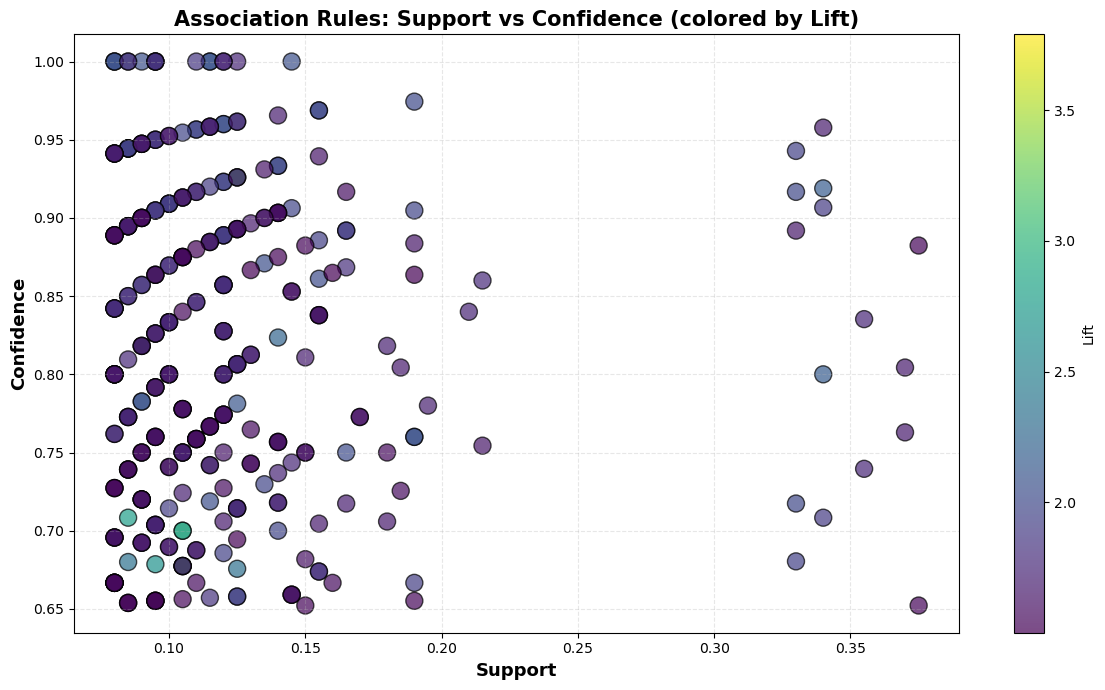

In [19]:
plt.figure(figsize=(12, 7))

# 繪製散點圖，顏色代表 Lift
scatter = plt.scatter(
    quality_rules['support'], 
    quality_rules['confidence'],
    c=quality_rules['lift'], 
    cmap='viridis', 
    s=150, 
    alpha=0.7,
    edgecolors='black',
    linewidths=1
)

# 添加顏色條
cbar = plt.colorbar(scatter, label='Lift')
cbar.ax.tick_params(labelsize=10)

plt.xlabel('Support', fontsize=13, fontweight='bold')
plt.ylabel('Confidence', fontsize=13, fontweight='bold')
plt.title('Association Rules: Support vs Confidence (colored by Lift)', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()

# 保存圖片
fig_path = FIG_DIR / 'support_confidence_scatter.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ 圖片已保存: {fig_path}")

plt.show()

---
### 8. 規則網絡圖視覺化

使用網絡圖展示項目之間的關聯關係，邊的粗細代表 Lift 強度。

繪製 Lift > 2.0 的規則網絡圖 (99 條規則)...
✓ 圖片已保存: d:\MyGit\CHE-AI-COURSE\Part_2\Unit08\outputs\P2_Unit08_Apriori_Algorithm\figs\rules_network.png


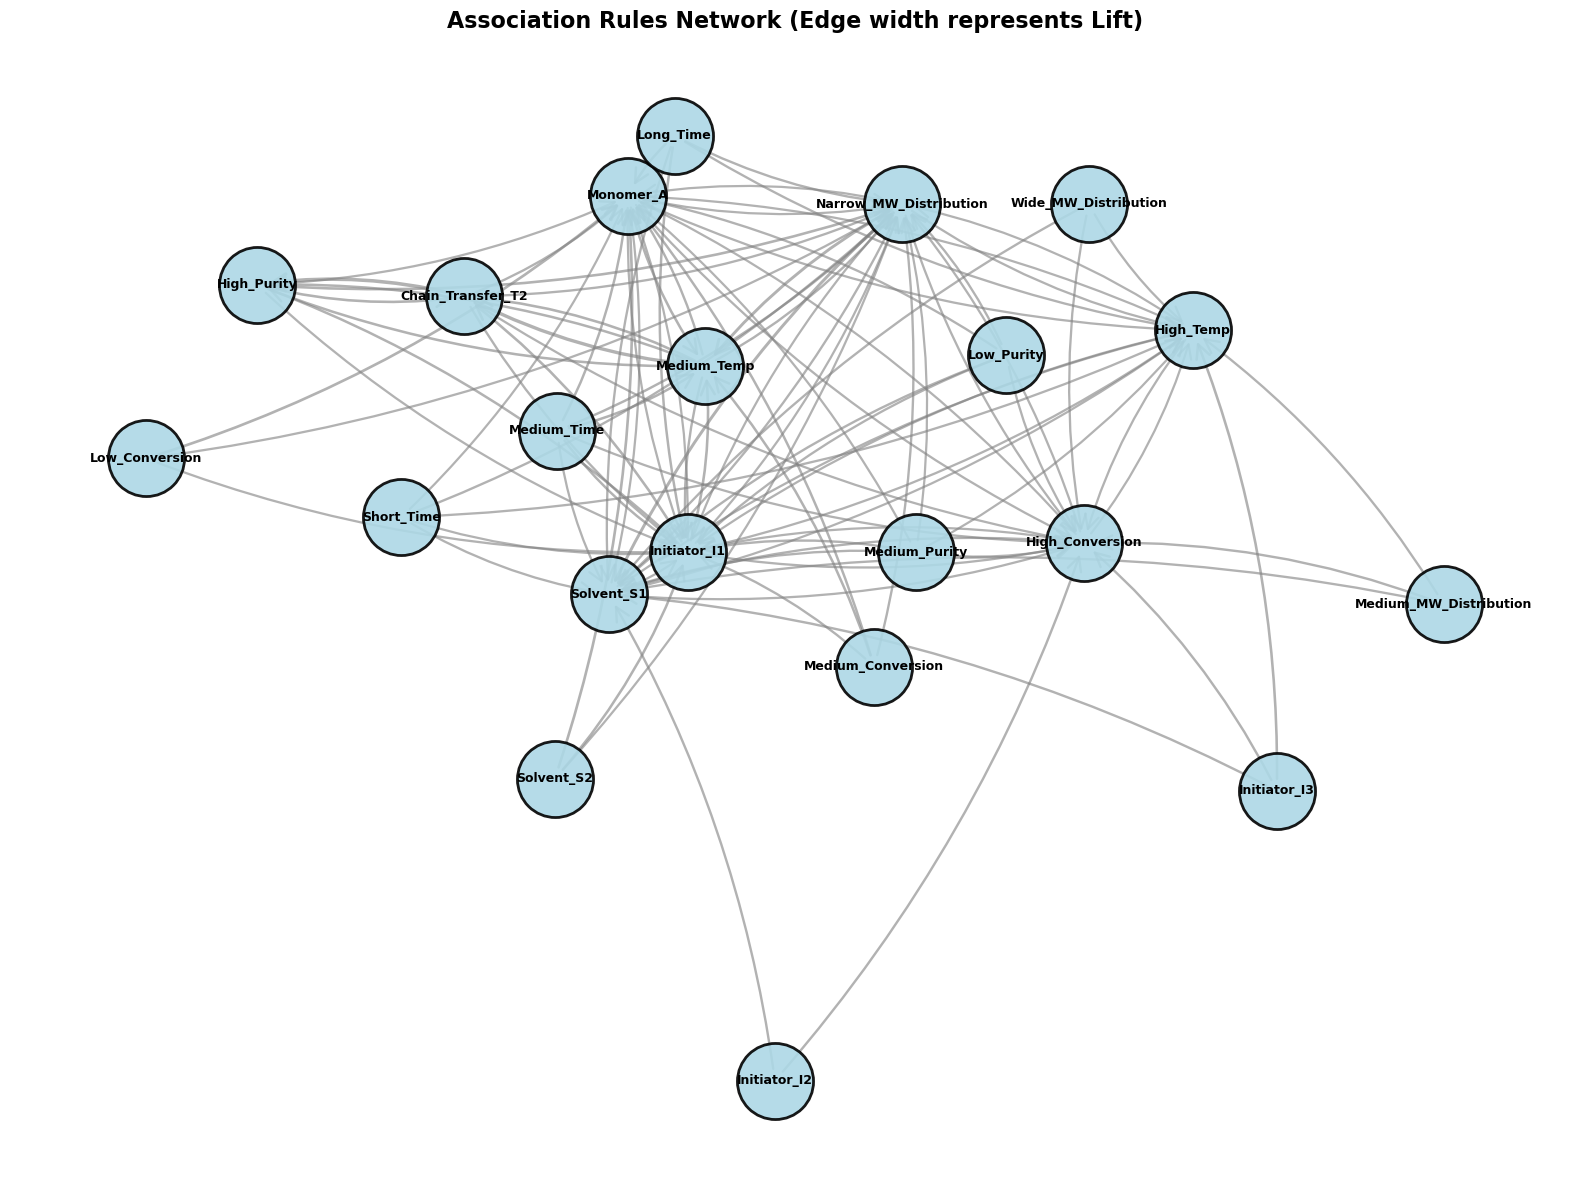

In [20]:
# 選擇 Lift > 2.0 的頂級規則
top_rules = quality_rules[quality_rules['lift'] > 2.0]

print(f"繪製 Lift > 2.0 的規則網絡圖 ({len(top_rules)} 條規則)...")

# 建立有向圖
G = nx.DiGraph()

for idx, rule in top_rules.iterrows():
    for antecedent in rule['antecedents']:
        for consequent in rule['consequents']:
            G.add_edge(
                antecedent, 
                consequent, 
                weight=rule['lift'],
                confidence=rule['confidence']
            )

# 繪製網絡圖
plt.figure(figsize=(16, 12))
pos = nx.spring_layout(G, k=1.5, iterations=50, seed=SEED)

# 繪製節點
nx.draw_networkx_nodes(
    G, pos, 
    node_size=3000, 
    node_color='lightblue', 
    alpha=0.9,
    edgecolors='black',
    linewidths=2
)

# 添加節點標籤
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')

# 繪製邊（粗細代表 Lift）
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
nx.draw_networkx_edges(
    G, pos, 
    width=[w*0.8 for w in weights], 
    alpha=0.6, 
    edge_color='gray',
    arrows=True, 
    arrowsize=25,
    arrowstyle='->',
    connectionstyle='arc3,rad=0.1'
)

plt.title('Association Rules Network (Edge width represents Lift)', 
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()

# 保存圖片
fig_path = FIG_DIR / 'rules_network.png'
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
print(f"✓ 圖片已保存: {fig_path}")

plt.show()

---
### 9. 進階分析：按品質指標分組規則

將規則按後項品質指標分組，找出不同品質指標的前驅因素。

In [21]:
# 定義品質指標類別
quality_targets = {
    'Narrow_MW_Distribution': '窄分子量分布',
    'High_Conversion': '高轉化率',
    'High_Purity': '高純度'
}

print("品質指標相關規則分析:\n")
print("="*80)

# 檢查 quality_rules 是否為空
if len(quality_rules) == 0:
    print("\n⚠️ 未找到符合條件的高品質規則 (Lift > 1.5, Confidence > 0.65)")
    print("\n建議：降低過濾條件以發現更多規則")
    print("  - 嘗試降低 min_support 至 0.05")
    print("  - 嘗試降低 Lift 閾值至 1.2")
    print("  - 嘗試降低 Confidence 閾值至 0.6")
    print("\n改用所有規則進行分析...\n")
    analysis_rules = rules  # 使用所有規則
else:
    analysis_rules = quality_rules  # 使用高品質規則

for target, target_name in quality_targets.items():
    # 過濾包含該品質指標的規則
    target_rules = analysis_rules[
        analysis_rules['consequents'].apply(lambda x: target in x)
    ]
    
    if len(target_rules) > 0:
        # 只有在有數據時才排序
        target_rules = target_rules.sort_values('lift', ascending=False)
        print(f"\n【{target_name}】相關規則 (Top 5):\n")
        for idx, rule in target_rules.head(5).iterrows():
            ante_str = ', '.join(rule['antecedents'])
            cons_str = ', '.join(rule['consequents'])
            print(f"  規則: {{{ante_str}}} => {{{cons_str}}}")
            print(f"    Support: {rule['support']:.3f}, Confidence: {rule['confidence']:.3f}, Lift: {rule['lift']:.3f}")
            print()
    else:
        print(f"\n【{target_name}】: 未發現相關規則\n")

print("="*80)

品質指標相關規則分析:


【窄分子量分布】相關規則 (Top 5):

  規則: {Monomer_A, High_Temp, Initiator_I1} => {High_Conversion, Narrow_MW_Distribution}
    Support: 0.105, Confidence: 0.677, Lift: 3.662

  規則: {Monomer_A, High_Conversion, Initiator_I1} => {High_Temp, Narrow_MW_Distribution}
    Support: 0.105, Confidence: 0.677, Lift: 3.662

  規則: {Monomer_A, Solvent_S1, High_Conversion} => {High_Temp, Narrow_MW_Distribution}
    Support: 0.095, Confidence: 0.655, Lift: 3.541

  規則: {Monomer_A, Low_Conversion, Initiator_I1} => {Narrow_MW_Distribution}
    Support: 0.085, Confidence: 1.000, Lift: 2.353

  規則: {Monomer_A, Initiator_I1, High_Purity} => {Narrow_MW_Distribution}
    Support: 0.095, Confidence: 1.000, Lift: 2.353


【高轉化率】相關規則 (Top 5):

  規則: {High_Temp, Solvent_S1, Narrow_MW_Distribution} => {Monomer_A, High_Conversion}
    Support: 0.095, Confidence: 0.826, Lift: 3.755

  規則: {Monomer_A, High_Temp, Initiator_I1} => {High_Conversion, Narrow_MW_Distribution}
    Support: 0.105, Confidence: 0.677, Lift:

---
### 10. 結果總結與業務洞察

In [22]:
print("="*80)
print("Apriori 演算法分析總結")
print("="*80)

print(f"\n【數據統計】")
print(f"  交易數量: {len(transactions)}")
print(f"  項目總數: {len(df.columns)}")
print(f"  頻繁項目集數量: {len(frequent_itemsets)}")
print(f"  關聯規則總數: {len(rules)}")
print(f"  高品質規則數量 (Lift>1.5, Conf>0.65): {len(quality_rules)}")

print(f"\n【關鍵發現】")
if rule1_found:
    print(f"  ✓ 規則 1: Monomer_A + Initiator_I1 → 窄分子量分布（協同效應已驗證）")
else:
    print(f"  ✗ 規則 1 未達顯著性，可能需要更多數據或調整參數")

if rule2_found:
    print(f"  ✓ 規則 2: Solvent_S1 + 高溫 → 高轉化率（協同效應已驗證）")
else:
    print(f"  ✗ 規則 2 未達顯著性，可能需要更多數據或調整參數")

if rule3_found:
    print(f"  ✓ 規則 3: Chain_Transfer_T2 + 中溫 → 高純度（協同效應已驗證）")
else:
    print(f"  ✗ 規則 3 未達顯著性，可能需要更多數據或調整參數")

print(f"\n【業務建議】")
print(f"  1. 配方標準化: 將 Lift > 1.5 的規則納入配方設計指南")
print(f"  2. 實驗驗證: 對新發現的規則進行小規模試產驗證")
print(f"  3. 知識管理: 建立配方知識庫，定期更新規則")
print(f"  4. 持續優化: 隨著新數據累積，定期重新運行分析")

print(f"\n【參數設定說明】")
print(f"  當前 min_support = {min_support} (需至少出現 {int(min_support * len(transactions))} 次)")
print(f"  當前 min_confidence = {min_confidence}")
print(f"  當前高品質閾值: Lift > 1.5, Confidence > 0.65")
print(f"  調整建議: 若規則過少，可降低 min_support 至 0.05；若規則過多，可提高 Lift 閾值至 2.0")

print("\n" + "="*80)
print("✓ 分析完成！所有結果已保存至 outputs 目錄")
print("="*80)

Apriori 演算法分析總結

【數據統計】
  交易數量: 200
  項目總數: 29
  頻繁項目集數量: 415
  關聯規則總數: 825
  高品質規則數量 (Lift>1.5, Conf>0.65): 368

【關鍵發現】
  ✓ 規則 1: Monomer_A + Initiator_I1 → 窄分子量分布（協同效應已驗證）
  ✓ 規則 2: Solvent_S1 + 高溫 → 高轉化率（協同效應已驗證）
  ✓ 規則 3: Chain_Transfer_T2 + 中溫 → 高純度（協同效應已驗證）

【業務建議】
  1. 配方標準化: 將 Lift > 1.5 的規則納入配方設計指南
  2. 實驗驗證: 對新發現的規則進行小規模試產驗證
  3. 知識管理: 建立配方知識庫，定期更新規則
  4. 持續優化: 隨著新數據累積，定期重新運行分析

【參數設定說明】
  當前 min_support = 0.08 (需至少出現 16 次)
  當前 min_confidence = 0.5
  當前高品質閾值: Lift > 1.5, Confidence > 0.65
  調整建議: 若規則過少，可降低 min_support 至 0.05；若規則過多，可提高 Lift 閾值至 2.0

✓ 分析完成！所有結果已保存至 outputs 目錄
